# Uploading dataset

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from IPython.display import display
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

RANDOM_STATE = 12345
RMSE_THRESHOLD = 48
TRAIN_SET_SHARE = 0.9
TEST_SET_SHARE = 0.1
CV_FOLDS = 5
SCORER = "neg_root_mean_squared_error"

# Setting visuals
sns.set_theme()

We have time series data so we should specify a column with dates as index of the DataFrame, which we will also have to sort in order to be time-consistent.

In [2]:
# Loading time-series data to a DataFrame
taxi_data = pd.read_csv("datasets/taxi.csv", parse_dates=[0], index_col=[0])

In [3]:
# Sorting the DataFrame Index
taxi_data.sort_index(inplace=True)

# Verifying the correctness of index values
taxi_data.index.is_monotonic_increasing == True

True

In [4]:
display(taxi_data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
display(taxi_data.tail())

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


For forecasting we will actually need to resample the data by one hour.

In [6]:
periodicity = "1H"
taxi_data_resampled = taxi_data.resample(periodicity).sum()

display(taxi_data_resampled.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Summary**

This initial section enables us to set up all necessary libraries and load the data, which has been correctly saved in the DataFrame and resampled by 1 hour.

# Data analysis

In [7]:
taxi_data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There seem to be no missing values in the DataFrame containing only one `num_orders` column (number of taxi orders). Additionally, we can see data correctly resampled by hour and having `DatetimeIndex`. Now, let's look at how numbers of orders are distributed.

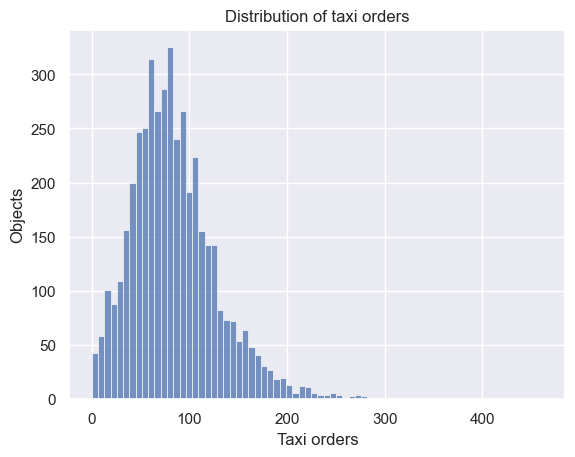

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,462.0


In [8]:
histogram = sns.histplot(data=taxi_data_resampled, x="num_orders")
histogram.set(
    title="Distribution of taxi orders",
    xlabel="Taxi orders",
    ylabel="Objects",
)
plt.show()

display(taxi_data_resampled.describe().round(2).T)

We can also visualize the data in a slightly different way - as a time series. For that, we will write a class `TimeSeriesPlotter` that will include a method called `plot_time_series` that will display time series graph of the data for a specific time period and `plot_decomposed` that will decompose the time series and plot its components.

In [9]:
class TimeSeriesPlotter:
    """Plots time-series data.

    Class provides two ways of plotting
    time-series data:

    - Plotting a time-series itself;
    - Plotting a decomposed time-series.

    Methods
    -------
    plot_decomposed()
        Decomposes a time-series into trend, seasonal
        and residual components and plots them together.
    plot_time_series()
        Plots a plain time-series (resampled or not)
        for a particular time period.

    Notes
    -----
    The private methods are as follows:

        _check_monotonicity()
            Verifies the consistency of dates in time-series
            DataFrame.
        _resample_data()
            Resamples the time-series data according to
            the value of `periodicity` parameter.
    """

    def __init__(self):
        """Constructor for TimeSeriesPlotter class."""
        pass

    def _check_monotonicity(self, data) -> None:
        """Checks in DataFrame time index is monotonically increasing."""
        if data.index.is_monotonic_increasing is False:
            raise RuntimeError("Inconsistent dates")

    def _resample_data(self, data, periodicity="1H"):
        """Resamples the data accordingly."""
        # Checking the consistency of dates
        self._check_monotonicity(data=data)
        # Resampling the data
        data_resampled = data.resample(periodicity).sum()

        return data_resampled

    def plot_decomposed(
        self,
        data,
        periodicity="1H",
        period=None,
        figure_dims=(8, 10),
        ylabel_name="ylabel_name",
    ):
        """Plots a time-series decomposition."""
        # Checking the consistency of dates
        self._check_monotonicity(data=data)

        # Resampling the data
        data_resampled = self._resample_data(data=data, periodicity=periodicity)
        # Decomposing time-series data
        decomposed = seasonal_decompose(data_resampled)

        # Creating and plotting a figure
        plt.figure(figsize=figure_dims)

        # Selecting the period
        if period is not None:
            period_start, period_end = period

            trend = decomposed.trend[period_start:period_end]
            seasonal = decomposed.seasonal[period_start:period_end]
            resid = decomposed.resid[period_start:period_end]
        else:
            trend = decomposed.trend
            seasonal = decomposed.seasonal
            resid = decomposed.resid

        # Plotting a trend component
        plt.subplot(311)
        trend_plot = sns.lineplot(data=trend, ax=plt.gca())
        trend_plot.set(title="Trend", xlabel="Time period", ylabel=ylabel_name)
        plt.xticks(rotation=45)

        # Plotting a seasonal component
        plt.subplot(312)
        seasonal_plot = sns.lineplot(data=seasonal, ax=plt.gca())
        seasonal_plot.set(title="Seasonality", xlabel="Time period", ylabel=ylabel_name)
        plt.xticks(rotation=45)

        # Plotting a residual component
        plt.subplot(313)
        residual_plot = sns.lineplot(data=resid, ax=plt.gca())
        residual_plot.set(title="Residual", xlabel="Time period", ylabel=ylabel_name)
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def plot_time_series(
        self,
        data,
        periodicity="1H",
        resample=True,
        period=None,
        figure_dims=None,
        title_name="title_name",
        ylabel_name="ylabel_name",
    ):
        """Plots a time-series."""
        # Checking the consistency of dates
        self._check_monotonicity(data=data)

        # Copying the data in a separate variable
        data_resampled = data.copy()

        # Resampling the data if needed
        if resample:
            data_resampled = self._resample_data(data=data, periodicity=periodicity)

        # Plotting a figure
        plt.figure(figsize=figure_dims)

        # Retrieving the data to plot
        data_to_plot = data_resampled.copy()

        # Selecting the period
        if period is not None:
            period_start, period_end = period
            data_to_plot = data_resampled[period_start:period_end]

        # Plotting a time series
        full_data_plot = sns.lineplot(data=data_to_plot, ax=plt.gca())
        full_data_plot.set(title=title_name, xlabel="Time period", ylabel=ylabel_name)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

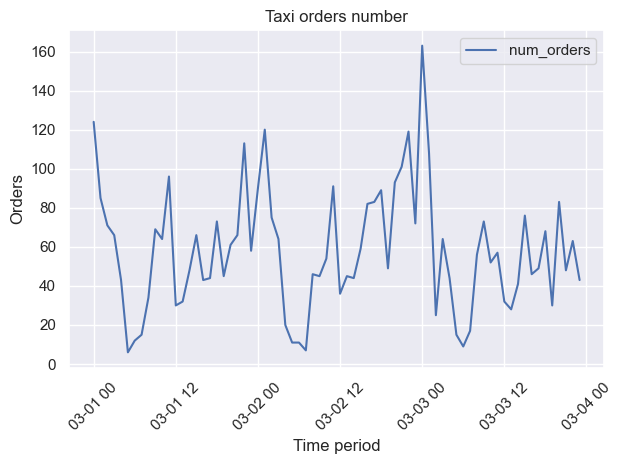

In [10]:
# Instantiating an object
ts_plotter = TimeSeriesPlotter()

# Plotting the time-series
ts_plotter.plot_time_series(
    data=taxi_data,
    resample=True,
    period=("2018-03-01", "2018-03-03"),
    title_name="Taxi orders number",
    ylabel_name="Orders",
)

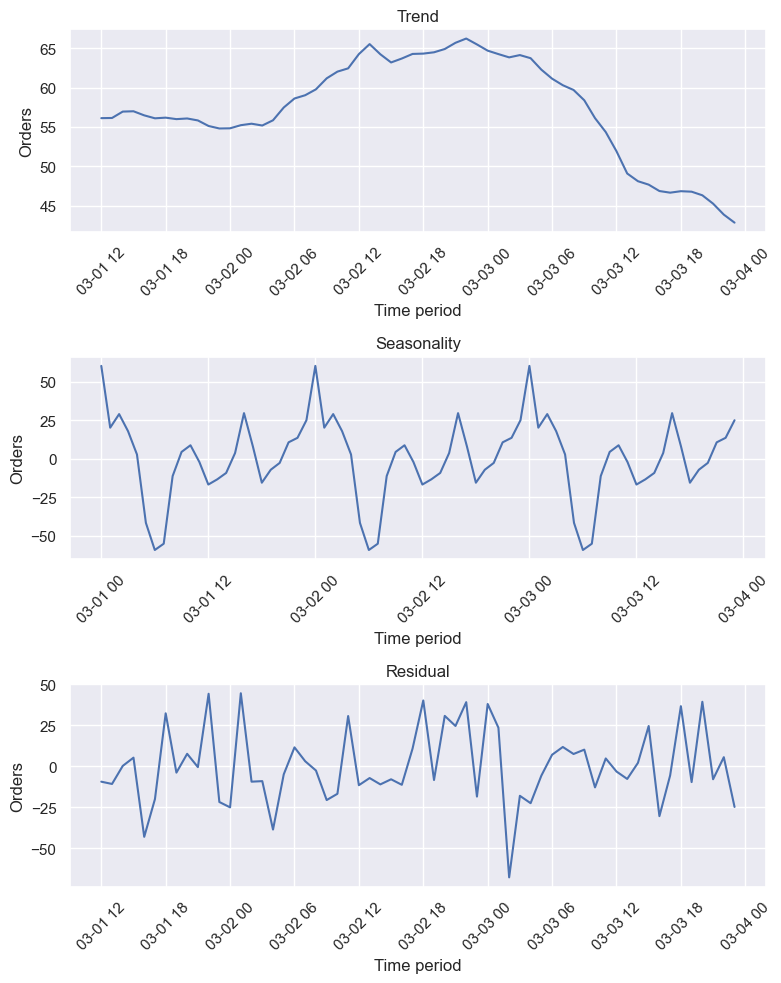

In [11]:
# Plotting a decomposed time-series
ts_plotter.plot_decomposed(
    data=taxi_data, period=("2018-03-01", "2018-03-03"), ylabel_name="Orders"
)

We see here that there is a certain periodicity in taxi orders: every day at about 6 o'clock in the morning, orders reach their minimum and then grow, fluctuating, until reaching their maximum at midnight, after which the pattern repeats again. This fact makes us think about the possibility of the value of hours having an impact on the number of orders.

**Summary**

This stage was devoted to data visualization, where we were able to decompose the time series into three components: trend, seasonality and residual. The function we have written enabled us to visualize any period of time within the time series period as well as display the results of the seasonal decomposition of the series.

# Data preparation

## Features extraction

Now let's move on to data preparation. To begin with, we need to actually create a dataset so that it can then be passed on to machine learning algorithms, because we have only one column, which is also a target feature. What we can do is create time variables from the DataFrame index itself, and also introduce lag values of the target attribute and a moving average as features. For that, we use write a class called `FeaturesExtractor` which will help us with that.

In [12]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):
    """Implements feature engineering for a time series DataFrame.

    Parameters
    ----------
    col_name : str
        The name of the column containing
        time-series data.
    max_lag : int, default=1
        Maximum lag to consider when creating
        new features.
    rolling_mean_order : int, default=1
        Order of the rolling mean to consider
        when creating new features.

    Methods
    -------
    fit()
        Returns the object itself.
    transform()
        Adds newly created time features
        to a DataFrame.

    Notes
    -----
    The class possesses the following private methods:

        _compute_lags()
            Adds a number of features to data according
            to the value of `max_lag`.
        _compute_rolling_mean()
            Adds rolling mean variable with order according
            to the value of `rolling_mean_order`.
    """

    def __init__(self, col_name, max_lag=1, rolling_mean_order=1):
        """Constructor for FeaturesExtractor class."""
        self.col_name = col_name
        self.max_lag = max_lag
        self.rolling_mean_order = rolling_mean_order

    def fit(self, X, y=None):
        """Returns the object itself."""
        return self

    def _compute_lags(self, data):
        """Computes lags."""
        for lag in range(1, self.max_lag + 1):
            data[f"lag_{lag}"] = data[self.col_name].shift(lag)

        return data

    def _compute_rolling_mean(self, data):
        """Computes rolling mean."""
        data[f"rolling_mean_{self.rolling_mean_order}"] = (
            data[self.col_name].shift().rolling(self.rolling_mean_order).mean()
        )

        return data

    def transform(self, X, y=None):
        """
        Extracts features from DateTimeIndex in accordance
        with arguments passed to `__init__`.
        """
        # Adding time variables
        X["quarter"] = X.index.quarter
        X["month"] = X.index.month
        X["day"] = X.index.day
        X["hour"] = X.index.hour
        # Adding lags
        X = self._compute_lags(data=X)
        # Adding moving average
        X = self._compute_rolling_mean(data=X)

        return X

In [13]:
features_extractor = FeaturesExtractor(col_name="num_orders")
features_extractor.get_params()

{'col_name': 'num_orders', 'max_lag': 1, 'rolling_mean_order': 1}

So, we see that we have successfully created a class object and its parameters were initialized with their default values. 

Everything is fine, but the question arises about which parameters it would be better to set for the class object, because the final quality of the models will depend on this. We will proceed as follows: first, we will create a grid `dataset_size_setter` with all possible and reasonable values for class parameters.

In [14]:
dataset_size_setter = {
    "max_lag": np.arange(1, 5),
    "rolling_mean_order": np.arange(1, 5),
}
display(dataset_size_setter)

{'max_lag': array([1, 2, 3, 4]), 'rolling_mean_order': array([1, 2, 3, 4])}

Now, we can actually convert this dictionary of arrays into a list of dictionaries with keys initialized by all possible combinations of parameter values.

In [15]:
keys, values = zip(*dataset_size_setter.items())
config_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
config_num = len(config_list)
print(f"Number of model configurations: {config_num:,}")

Number of model configurations: 16


In [16]:
config_list

[{'max_lag': 1, 'rolling_mean_order': 1},
 {'max_lag': 1, 'rolling_mean_order': 2},
 {'max_lag': 1, 'rolling_mean_order': 3},
 {'max_lag': 1, 'rolling_mean_order': 4},
 {'max_lag': 2, 'rolling_mean_order': 1},
 {'max_lag': 2, 'rolling_mean_order': 2},
 {'max_lag': 2, 'rolling_mean_order': 3},
 {'max_lag': 2, 'rolling_mean_order': 4},
 {'max_lag': 3, 'rolling_mean_order': 1},
 {'max_lag': 3, 'rolling_mean_order': 2},
 {'max_lag': 3, 'rolling_mean_order': 3},
 {'max_lag': 3, 'rolling_mean_order': 4},
 {'max_lag': 4, 'rolling_mean_order': 1},
 {'max_lag': 4, 'rolling_mean_order': 2},
 {'max_lag': 4, 'rolling_mean_order': 3},
 {'max_lag': 4, 'rolling_mean_order': 4}]

Let's choose some configuration (number 7, for example) and create the dataset.

In [17]:
config_idx = 6
config_selected = config_list[config_idx]
config_selected

{'max_lag': 2, 'rolling_mean_order': 3}

In [18]:
features_extractor = features_extractor.set_params(**config_selected)
features_extractor.get_params()

{'col_name': 'num_orders', 'max_lag': 2, 'rolling_mean_order': 3}

In [19]:
taxi_dataset = features_extractor.fit_transform(taxi_data_resampled)
taxi_dataset.head()

,num_orders,quarter,month,day,hour,lag_1,lag_2,rolling_mean_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,3,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,1,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,1,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,1,4,66.0,71.0,74.000000


We can now see that all four time variables have been created in addition to two lagged columns of `num_orders` as well as moving average of order 3.

## Correlation matrix

Let's now plot correlation matrix heatmap using a function we will write.

In [20]:
def plot_corr_heatmap(
    data,
    annotation=False,
    annot_num_size=None,
    heatmap_coloring=None,
    upper_triangle=False,
    lower_triangle=False,
):
    """Plots a heatmap for the correlation matrix.

    Parameters
    ----------
    data : DataFrame
        DataFrame for which a heatmap needs to be plotted.
    annotation : bool, default=False
        Boolean indicator of displaying numbers in the heatmap.
    annot_num_size : int or None, default=None
        Size of the figures inside the plot.
    heatmap_coloring : Colormap or None, default=None
        Heatmap colormap.
    upper_triangle : bool, default=False
        Boolean indicator of displaying only the upper triangle of
        the matrix.
    lower_triangle : bool, default=False
        Boolean indicator of displaying only the lower triangle of
        the matrix.
    """
    # Computing the correlation matrix
    corr_matrix = data.corr()

    # Showing upper triangle of a matrix
    if upper_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.tril_indices_from(mask)] = True
    # Showing lower triangle of a matrix
    elif lower_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True
    # Showing the entire matrix
    else:
        mask = None

    # Plotting a heatmap of the matrix
    corr_heatmap = sns.heatmap(
        corr_matrix,
        annot=annotation,
        mask=mask,
        annot_kws={"size": annot_num_size},
        cmap=heatmap_coloring,
    )
    corr_heatmap.xaxis.tick_bottom()
    corr_heatmap.yaxis.tick_left()
    corr_heatmap.set(title="Correlation matrix heatmap")

    plt.show()

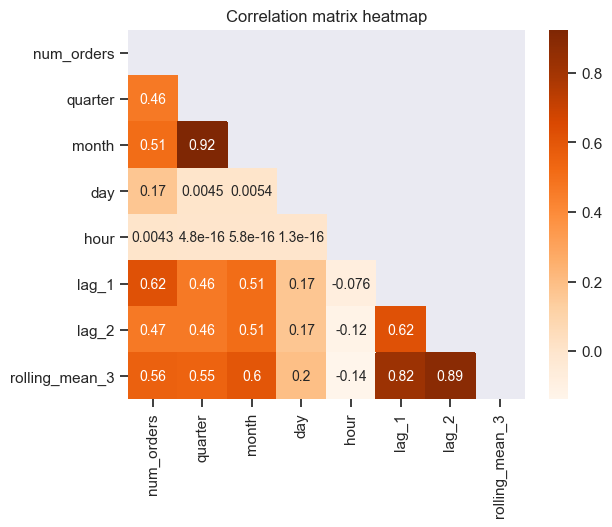

In [21]:
# Correlation matrix heatmap
plot_corr_heatmap(
    data=taxi_dataset,
    annot_num_size=10,
    annotation=True,
    heatmap_coloring="Oranges",
    lower_triangle=True,
)

The dataset has been successfully created and we see that many of the features are correlated with the target variable. Of course, `hour` column does not correlate well with the number of orders, but still the correlation does not imply causality, so we will leave it intact in the DataFrame and see later how important it will be for prediction.

## Data split

In [22]:
# Splitting the data into training and test sets
training_set, test_set = train_test_split(
    taxi_dataset, shuffle=False, test_size=TEST_SET_SHARE
)

# Getting rid of NaN values in the training data
training_set = training_set.dropna()

# Separating features from target
features_train = training_set.drop(["num_orders"], axis=1)
target_train = training_set["num_orders"]

features_test = test_set.drop(["num_orders"], axis=1)
target_test = test_set["num_orders"]

In [23]:
features_train_share = np.round(features_train.shape[0] / taxi_dataset.shape[0], 2)
target_train_share = np.round(target_train.shape[0] / taxi_dataset.shape[0], 2)

features_test_share = np.round(features_test.shape[0] / taxi_dataset.shape[0], 2)
target_test_share = np.round(target_test.shape[0] / taxi_dataset.shape[0], 2)

assert features_train_share == target_train_share == TRAIN_SET_SHARE
assert features_test_share == target_test_share == TEST_SET_SHARE

**Summary**

At this stage, we were able to prepare data for machine learning algorithms. In particular, we were able to create a dataset by extracting features from the dataframe index and its data, and also divided the data into samples.

# Hyperparameter tuning

Now we move on to training models, which we will do by selecting hyperparameters. Consider the following regression models:

1. `DecisionTreeRegressor()`
2. `RandomForestRegressor()`
3. `CatBoostRegressor()`
4. `XGBRegressor()`
5. `LGBMRegressor()`

Since we deal with time series data, we will use an appropriate cross-validator.

In [24]:
tscv = TimeSeriesSplit(n_splits=CV_FOLDS, test_size=target_test.shape[0])

## Parameter grids

In [25]:
decision_tree_params_grid = {"max_depth": np.arange(1, 15)}

In [26]:
random_forest_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [27]:
catboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [28]:
xgboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [29]:
lgbm_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

## Models

In [30]:
decision_tree_model = DecisionTreeRegressor(random_state=12345)

In [31]:
random_forest_model = RandomForestRegressor(random_state=12345)

In [32]:
catboost_model = CatBoostRegressor(verbose=0)

In [33]:
xgboost_model = XGBRegressor()

In [34]:
lgbm_model = LGBMRegressor()

## Selection

### `DecisionTree`

In [35]:
%%time

# Instantiating GSCV object
decision_tree_grid_search = GridSearchCV(
    estimator=decision_tree_model,
    param_grid=decision_tree_params_grid,
    cv=tscv,
    scoring=SCORER,
    verbose=1,
)

# Launching grid search
decision_tree_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Decision tree): {-decision_tree_grid_search.best_score_:.2f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
RMSE (Decision tree): 30.83
CPU times: total: 2.16 s
Wall time: 2.17 s


In [36]:
# Displaying the best hyperparameters
display(decision_tree_grid_search.best_params_)

{'max_depth': 7}

### `RandomForest`

In [37]:
%%time

# Instantiating GSCV object
random_forest_grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=random_forest_params_grid,
    cv=tscv,
    scoring=SCORER,
    verbose=1,
)

# Launching a grid search
random_forest_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Random forest): {-random_forest_grid_search.best_score_:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE (Random forest): 28.99
CPU times: total: 49.5 s
Wall time: 49.7 s


In [38]:
# Displaying the best hyperparameters
display(random_forest_grid_search.best_params_)

{'max_depth': 6, 'n_estimators': 40}

### `Catboost`

In [39]:
%%time

# Instantiating GSCV object
catboost_grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_params_grid,
    cv=tscv,
    scoring=SCORER,
    verbose=1,
)

# Launching grid search
catboost_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (Catboost): {-catboost_grid_search.best_score_:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE (Catboost): 26.47
CPU times: total: 1min 15s
Wall time: 24.9 s


In [40]:
# Displaying the best hyperparameters
display(catboost_grid_search.best_params_)

{'max_depth': 4, 'n_estimators': 40}

### `XGBoost`

In [41]:
%%time

# Instantiating GSCV object
xgboost_grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=xgboost_params_grid,
    cv=tscv,
    scoring=SCORER,
    verbose=1,
)

# Launching grid search
xgboost_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (XGBoost): {-xgboost_grid_search.best_score_:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE (XGBoost): 26.78
CPU times: total: 1min 18s
Wall time: 10.4 s


In [42]:
# Displaying the best hyperparameters
display(xgboost_grid_search.best_params_)

{'max_depth': 3, 'n_estimators': 40}

### `LGBM`

In [43]:
%%time

# Instantiating GSCV object
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_params_grid,
    cv=tscv,
    scoring=SCORER,
    verbose=1,
)

# Launching grid search
lgbm_grid_search.fit(features_train, target_train)

# Displaying the best score
print(f"RMSE (LightGBM): {-lgbm_grid_search.best_score_:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE (LightGBM): 26.39
CPU times: total: 41.8 s
Wall time: 5.53 s


In [44]:
# Displaying the best hyperparameters
display(lgbm_grid_search.best_params_)

{'max_depth': 6, 'n_estimators': 60}

# Model analysis

In [45]:
def plot_model_comparison(
    results,
    metric_name="metric_name",
    title_name="title_name",
    dot_size=150,
    figure_dims=(15, 7),
    xticks_fontsize=15,
    yticks_fontsize=12,
    title_fontsize=20,
    ylabel_fontsize=15,
):
    """Provides models performance visualization.

    Generates a scatterplot with model names and their
    respective metric values for comparison.

    Parameters
    ----------
    results : list of tuples
        Sequence of tuples with model names and metric values.
    metric_name : str, default="metric_name"
        Name of the metric.
    title_name : str, default="title_name"
        Title of the plot.
    dot_size : int, default=150
        Size of scatterplot dots.
    figure_dims : tuple of integers, default=(15, 7)
        Dimensions of the figure.
    xticks_fontsize : int, default=15
        Size of xticks on the plot.
    yticks_fontsize : int, default=12
        Size of yticks on the plot.
    title_fontsize : int, default=20
        Size of the title of the plot.
    ylabel_fontsize : int, default=15
        Size of the Y-label.
    """
    # Separating scores from a sequence of tuples passed
    _, scores = zip(*results)
    # Joining model names with scores
    names_with_scores = [f"{name}\n{loss:.4f}" for name, loss in results]

    # Making a plot
    plt.figure(figsize=figure_dims)

    plt.scatter(range(len(results)), scores, s=dot_size)

    plt.xticks(range(len(results)), names_with_scores, fontsize=xticks_fontsize)
    plt.yticks(fontsize=yticks_fontsize)
    plt.ylabel(metric_name, fontsize=ylabel_fontsize)
    plt.title(title_name, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

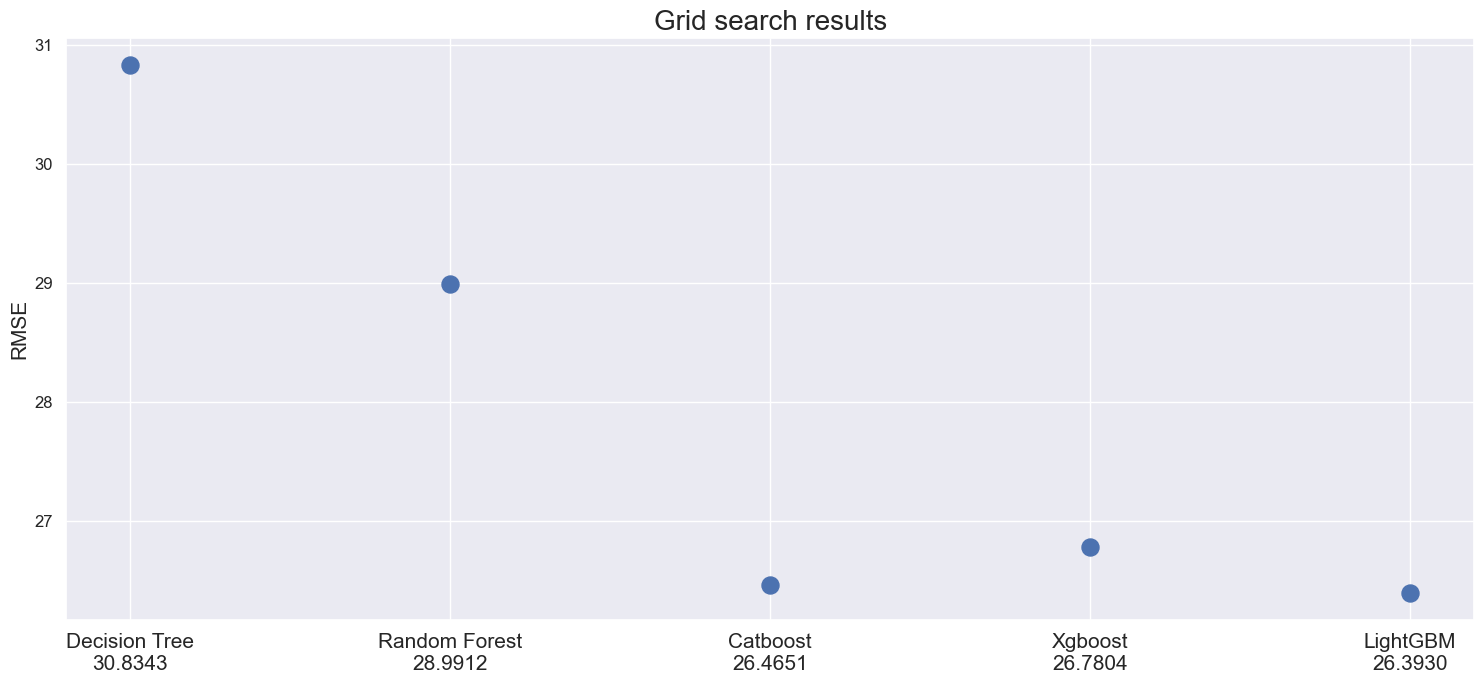

In [46]:
results = [
    ("Decision Tree", -decision_tree_grid_search.best_score_),
    ("Random Forest", -random_forest_grid_search.best_score_),
    ("Catboost", -catboost_grid_search.best_score_),
    ("Xgboost", -xgboost_grid_search.best_score_),
    ("LightGBM", -lgbm_grid_search.best_score_),
]
plot_model_comparison(
    results,
    metric_name="RMSE",
    title_name="Grid search results",
)

In [47]:
final_model = lgbm_grid_search.best_estimator_

In [48]:
display(lgbm_grid_search.best_params_)

{'max_depth': 6, 'n_estimators': 60}

**Summary**

The results of hyperparameter tuning showed that it would be reasonable to select *LightGBM* model.

# Testing

In [49]:
# Computing predictions on the test set
predictions_test = final_model.predict(features_test)

# Computing test RMSE
rmse_test = mean_squared_error(
    y_true=target_test, y_pred=predictions_test, squared=False
)

# Test model performance check
assert rmse_test < RMSE_THRESHOLD, "Model quality is insufficient"

# Displaying the test score if sufficient quality present
print(f"Test score: {rmse_test:.4f}")

Test score: 44.3877


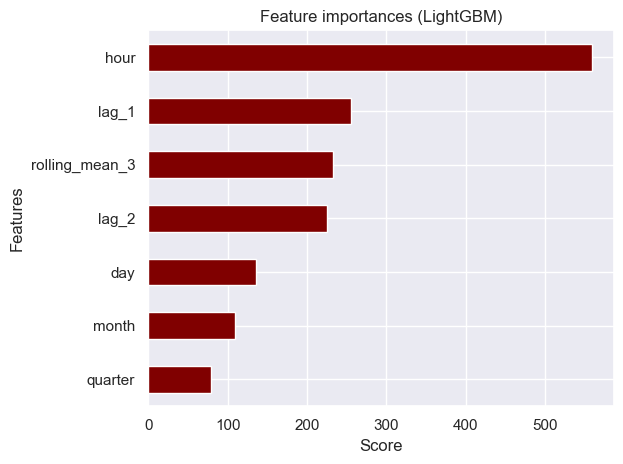

In [50]:
# Plotting feature importance
feature_importances = pd.Series(
    final_model.feature_importances_, index=features_train.columns
).sort_values()

feature_importances.plot(kind="barh", color="maroon")

plt.title("Feature importances (LightGBM)")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [51]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(y_true=target_test, y_pred=predictions_dummy, squared=False)

assert rmse_test < rmse_dummy, "Model is inadequate"

print(f"Dummy test RMSE: {rmse_dummy:.2f}")

Dummy test RMSE: 84.75


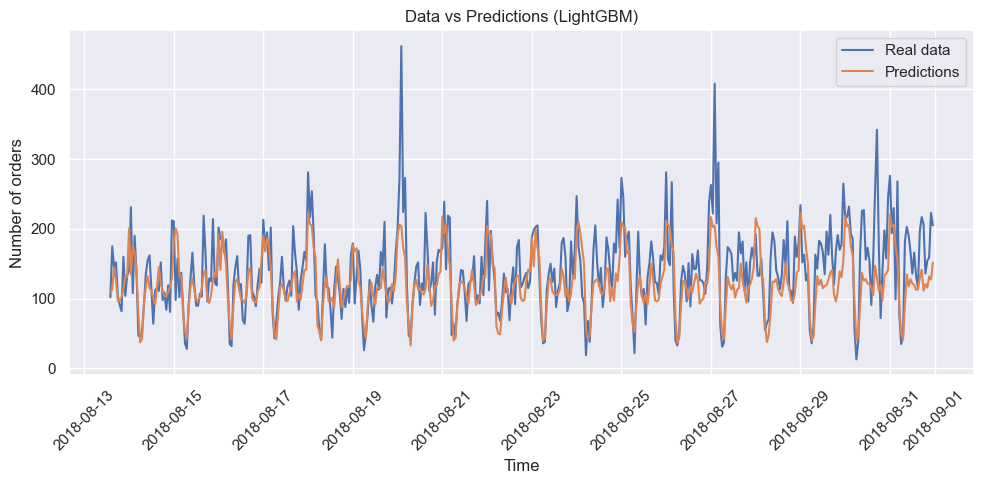

In [52]:
# Compiling a comparison of predictions with real data
predictions = pd.Series(
    predictions_test, index=target_test.index, name="num_orders_predicted"
)
predictions_comparison = pd.concat([target_test, predictions], axis=1)

# Plotting the predictions comparison
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders",
    label="Real data",
)
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders_predicted",
    label="Predictions",
)
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of orders")
plt.xlabel("Time")
plt.title("Data vs Predictions (LightGBM)")
plt.tight_layout()
plt.show()

In [53]:
display(predictions_comparison)

,num_orders,num_orders_predicted
datetime,,
2018-08-13 14:00:00,102,109.283703
2018-08-13 15:00:00,175,113.403956
2018-08-13 16:00:00,144,145.234055
2018-08-13 17:00:00,152,127.159387
2018-08-13 18:00:00,104,96.451596
...,...,...
2018-08-31 19:00:00,136,120.989266
2018-08-31 20:00:00,154,115.948519
2018-08-31 21:00:00,159,131.936823


**Summary**

Testing showed that the chosen model indeed passes both quality and adequacy checks. 

# General conclusion

This study was devoted to developing of a time series forecasting model, where the data was the number of orders at the airport. During the analysis, we visualized and analyzed the data. The data was also prepared by creating additional features for machine learning. During the training of models, we were able to choose the optimal combinations of hyperparameters for each of the models under consideration, the best of which, according to the test value of the metric *RMSE*, turned out to be *CatBoostRegressor*. It was also additionally established that hours are a particularly important factor in predicting order values.